<a id="section_CART"></a> 
## Workshop Final DS Digital House

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [11]:
# importando bases de treino e teste
df_test = pd.read_csv(r'https://raw.githubusercontent.com/faustinothiagos/Workshop_Final_DS_Digital_House_2022/main/DataSet/test.csv')
df_train = pd.read_csv(r'https://raw.githubusercontent.com/faustinothiagos/Workshop_Final_DS_Digital_House_2022/main/DataSet/train.csv')

c:\Users\Luquinhas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
# incluindo colunas para sperar os dados da mesma maneira que estavam originalmente
df_train['test'] = 0
df_test['test'] = 1

# incluindo coluna de score com nan nos dados de teste
df_test['Credit_Score'] = np.nan

In [23]:
# concatenando os datasets ja que eles tem as mesmas colunas

df_total = pd.concat([df_train, df_test], ignore_index = True)

In [27]:
print('dados de treino: ',df_train.shape)
print('dados de teste: ',df_test.shape)
print('todos os dados agrupados: ',df_total.shape)

dados de treino:  (100000, 29)
dados de teste:  (50000, 29)
todos os dados agrupados:  (150000, 29)


Colunas dataset:

* ID - Identificador de entrada
* Customer_ID - ID cliente
* Month - Mês do ano
* Name - nome do cliente
* Age - Idade Cliente
* SSN - Social Security Number (CPF no Brasil)
* Occupation - Ocupação do cliente
* Annual_Income - renda anual
* Monthly_Inhand_Salary - Salario mensal do cliente
* Num_Bank_Accounts - quantidade de contas em bancos
* Num_Credit_Card - quantidade de cartões de crédito
* Interest_Rate - taxa de juros cartão de crédito
* Num_of_Loan - Quantidade de empréstimos feitos no banco
* Type_of_Loan - tipo de empréstimo feito pelo cliente
* Delay_from_due_date - qtd. de dias de atraso pagamento cartão
* Num_of_Delayed_Payment - Média de pagamentos atrasado pelo cliente
* Changed_Credit_Limit - Variação percentual de limite do cartão de crédito
* Num_Credit_Inquiries - Quantidade de "cobranças" no cartão
* Credit_Mix - mix de crédito do cliente
* Outstanding_Debt - restante à ser pago da dívida
* Credit_Utilization_Ratio - Taxa de utlização do cartão de crédito
* Credit_History_Age - Tempo de histórico de crédito do cliente
* Payment_of_Min_Amount - Pagamento minimo
* Total_EMI_per_month - Pagamento fixo em dolares por mes
* Amount_invested_monthly - Quantidade de dinheiro investido pelo cliente mensalmente
* Payment_Behaviour - Comportamento de pagamento cliente
* Monthly_Balance - Saldo Mensal Cliente
* Credit_Score - Target
* test - coluna utilizada para separar o dataset nos dados de treino e teste

In [50]:
# quantidade % de dados faltantes
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title('% de dados faltantes')
        plt.show()
    else:
        print('No NAs found')

In [53]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  object 
 3   Name                      135000 non-null  object 
 4   Age                       150000 non-null  object 
 5   SSN                       150000 non-null  object 
 6   Occupation                150000 non-null  object 
 7   Annual_Income             150000 non-null  object 
 8   Monthly_Inhand_Salary     127500 non-null  float64
 9   Num_Bank_Accounts         150000 non-null  int64  
 10  Num_Credit_Card           150000 non-null  int64  
 11  Interest_Rate             150000 non-null  int64  
 12  Num_of_Loan               150000 non-null  object 
 13  Type_of_Loan              132888 non-null  o

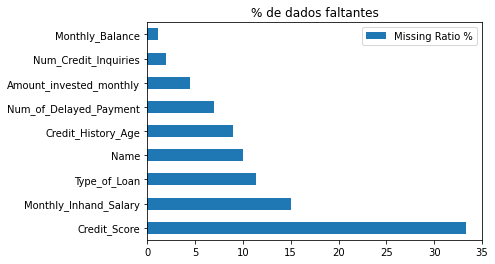

In [51]:
plot_nas(df_total)


In [60]:
# campos que fazem sentido permanecer

colunas_ul = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']
for row in colunas_ul:
    df_total[row] = df_total[row].str.replace(r'_+', '')

<ipython-input-60-cdf7e71b0c7d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_total[row] = df_total[row].str.replace(r'_+', '')


In [63]:
# removendo os underlines e colocando NaN
df_total['Occupation'] = df_total['Occupation'].replace('_______', np.nan)

In [64]:
df_total.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,test
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,0
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,0
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,0
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,0
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,0


In [65]:
df_total[df_total['Customer_ID'] == 'CUS_0xd40']

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,test
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good,0
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good,0
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good,0
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good,0
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good,0
5,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,809.98,27.262259,22 Years and 6 Months,No,49.574949,62.430172331195294,!@9#%8,340.4792117872438,Good,0
6,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,22.537593,22 Years and 7 Months,No,49.574949,178.3440674122349,Low_spent_Small_value_payments,244.5653167062043,Good,0
7,0x1609,CUS_0xd40,August,NaN,23,#F%$D@*&8,Scientist,19114.12,1824.843333,3,...,809.98,23.933795,NaN,No,49.574949,24.785216509052056,High_spent_Medium_value_payments,358.12416760938714,Standard,0
100000,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,35.030402,22 Years and 9 Months,No,49.574949,236.64268203272135,Low_spent_Small_value_payments,186.26670208571772,NaN,1
100001,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,809.98,33.053114,22 Years and 10 Months,No,49.574949,21.465380264657146,High_spent_Medium_value_payments,361.44400385378196,NaN,1
